In [1]:
import torch
from torchvision import transforms
from torchsummary import summary
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

import os, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")



In [2]:
from unet_3block_conv import *
from outils_prepro import * 
from data_loader_seg import *
from model_prob_unet_init import *

In [3]:
path_ori = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg\originals_180919\originals'
path = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg\ora_180919\Layers'
path_train_masks = os.path.join(path, 'train', 'mask')
path_train = os.path.join(path, 'train')


names_ = [f[:-25] for f in os.listdir(path_train_masks) if f.endswith('png') and 'sheet' in f]
print(len(names_))
names_.sort()


mask_nod = [ f  for f in os.listdir(path_train_masks) if f.endswith('png') and 'nodular' in f and  f[:-27] in names_ ]
names  = [f[:-27] for f in mask_nod ]

mask_nod = [ os.path.join(path_train_masks, f)  for f in os.listdir(path_train_masks) if f.endswith('png') and 'nodular' in f and  f[:-27] in names_ ]
mask_sh = [os.path.join(path_train_masks, f) for f in os.listdir(path_train_masks) if f.endswith('png') and 'sheet' in f  and  f[:-25] in names ]

image_Paths  = [os.path.join(path_train_masks, f) for f in os.listdir(path_train_masks) if (f.endswith('grayscale.png') or f.endswith('greyscale.png') )  and f[:-14] in names]
print(len(mask_nod), len(mask_sh), len(image_Paths))

mask_bck = [os.path.join(path_train_masks, f) for f in os.listdir(path_train_masks) if f.endswith('png') and 'ale._nonbck' in f  and f[:-22] in names]
#mask_bck = [os.path.join(path_train_masks, f) for f in os.listdir(path_train_masks) if f.endswith('png') and 'nonbck' in f  and f[:-12] in names]
#mask_bck = [os.path.join(path_train_masks, f) for f in os.listdir(path_train_masks) if f.endswith('png') and 'nonbck' in f]

print(len(mask_nod), len(mask_sh), len(mask_bck), len(image_Paths))
mask_bck.sort()

mask_nod.sort()
mask_sh.sort()
image_Paths.sort()

mask_Paths  = [[nod, sh]  for nod, sh in zip(mask_nod,mask_sh) ]

#mask_Paths  = [[nod, sh, bck]  for nod, sh, bck in zip(mask_nod,mask_sh,mask_bck) ]



78
76 76 76
76 76 76 76


In [4]:
error = 20
Area = 100
image_list = []
mask_list = []

for idx in range(len(mask_Paths)):
    #print(idx)
    mask =  create_binary_mask(mask_Paths, idx)
    image = read_image(image_Paths[idx], False )
    masks_imgs, imgs = box_image_seg(mask, image, error, Area)
    image_list += imgs
    mask_list += masks_imgs
print('Images and masks are created')
print(len(image_list), len(mask_list))     

Images and masks are created
135 135


In [5]:
input_channels = 3
num_classes = 3
filters = 8

if filters == 8:
    featureDim = 16384
if filters ==4:
    featureDim = 8192

z_dim = 10
image_shape = (128, 128) 

'''
model4 beta  = 10
epochs = 101

model 5 beta = 20
epochs = 301
'''
beta = 20
epochs = 101

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelPath = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg\model6'

data = SegmentationDataset(image_list, mask_list, image_shape)
dataloaders = torch.utils.data.DataLoader(data, 2)

for index, batch in enumerate(dataloaders): 
    if index <2:
        X, y = batch
        X, y = X.to(device), y.to(device)
    #print(X.shape, y.shape)


net = Probabilistic_UNET(input_channels, num_classes, filters, z_dim, image_shape, featureDim)
net.to(device)
#optimizer = torch.optim.Adam(net.parameters(), lr = 0.005)#
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=0)
#summary(net)


In [6]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# count_parameters(Probabilistic_UNET)
#sum(p.numel() for p in conv_3.parameters())

sum(p.numel() for p in net.parameters() if p.requires_grad) 

552529

In [7]:
train_loss = [] 
for epoch in range(epochs):
    for step, batch in enumerate(dataloaders): 
        X, y = batch
        patch, mask = X.to(device), y.to(device)
        
        rec_loss,  dkl_loss, _ =  net(patch,mask)      
        elbo =  -(rec_loss + beta * dkl_loss)
        if step % 30 == 0:
                # clear_output(wait=True)
                print('Current step: {}  Loss: {}  Recons: {}  dkl : {}'.format(step, -elbo, rec_loss, dkl_loss))
                
        loss = -elbo
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = loss / len(dataloaders.dataset)
    train_loss.append(epoch_loss)
    if epoch % 5 == 0: #Save model weight once every 60k steps permenant file
            print("Saving Model" +str(epoch) + ".torch")
            torch.save(net.state_dict(),   os.path.join(modelPath,str(epoch) + ".torch") )

ValueError: Target size (torch.Size([2, 128, 128])) must be the same as input size (torch.Size([2, 3, 128, 128]))

In [22]:
train_loss = [] 
for epoch in range(epochs):
    for step, batch in enumerate(dataloaders): 
        X, y = batch
        patch, mask = X.to(device), y.to(device)
        
        rec_loss,  dkl_loss, _ =  net(patch,mask)      
        elbo =  -(rec_loss + beta * dkl_loss)
        if step % 30 == 0:
                # clear_output(wait=True)
                print('Current step: {}  Loss: {}  Recons: {}  dkl : {}'.format(step, -elbo, rec_loss, dkl_loss))
                
        loss = -elbo
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = loss / len(dataloaders.dataset)
    train_loss.append(epoch_loss)
    if epoch % 5 == 0: #Save model weight once every 60k steps permenant file
            print("Saving Model" +str(epoch) + ".torch")
            torch.save(net.state_dict(),   os.path.join(modelPath,str(epoch) + ".torch") )

Current step: 0  Loss: 3696.080322265625  Recons: 0.733921468257904  dkl : 184.76731872558594
Current step: 30  Loss: 2600.7841796875  Recons: 0.7289628982543945  dkl : 130.0027618408203
Current step: 60  Loss: 2183.791259765625  Recons: 0.7179123163223267  dkl : 109.1536636352539
Saving Model0.torch
Current step: 0  Loss: 2156.846435546875  Recons: 0.7342249155044556  dkl : 107.80561828613281
Current step: 30  Loss: 1680.5694580078125  Recons: 0.7344070076942444  dkl : 83.99175262451172
Current step: 60  Loss: 1533.288330078125  Recons: 0.6965283155441284  dkl : 76.62959289550781
Current step: 0  Loss: 1469.7742919921875  Recons: 0.7300630807876587  dkl : 73.45220947265625
Current step: 30  Loss: 1210.6297607421875  Recons: 0.7183536291122437  dkl : 60.49557113647461
Current step: 60  Loss: 1141.294921875  Recons: 0.6999123096466064  dkl : 57.02975082397461
Current step: 0  Loss: 1063.1138916015625  Recons: 0.705283522605896  dkl : 53.12042999267578
Current step: 30  Loss: 919.5704345

In [19]:
train_loss = [] 
for epoch in range(epochs):
    for step, batch in enumerate(dataloaders): 
        X, y = batch
        patch, mask = X.to(device), y.to(device)
        
        rec_loss,  dkl_loss =  net(patch,mask)      
        elbo =  -(rec_loss + beta * dkl_loss)
        if step % 30 == 0:
                # clear_output(wait=True)
                print('Current step: {}  Loss: {}  Recons: {}  dkl : {}'.format(step, -elbo, rec_loss, dkl_loss))
                
        loss = -elbo
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = loss / len(dataloaders.dataset)
    train_loss.append(epoch_loss)
    if epoch % 5 == 0: #Save model weight once every 60k steps permenant file
            print("Saving Model" +str(epoch) + ".torch")
            torch.save(net.state_dict(),   os.path.join(modelPath,str(epoch) + ".torch") )

Current step: 0  Loss: 283.58056640625  Recons: 0.8588671684265137  dkl : 28.272171020507812
Current step: 30  Loss: 197.03033447265625  Recons: 0.8136314749717712  dkl : 19.62166976928711
Current step: 60  Loss: 163.9285430908203  Recons: 0.7443544864654541  dkl : 16.318418502807617
Saving Model0.torch
Current step: 0  Loss: 137.1516876220703  Recons: 0.8746190071105957  dkl : 13.627706527709961
Current step: 30  Loss: 118.83528137207031  Recons: 0.760791003704071  dkl : 11.807449340820312
Current step: 60  Loss: 104.12481689453125  Recons: 0.8199907541275024  dkl : 10.330482482910156
Current step: 0  Loss: 87.34896850585938  Recons: 0.8349778652191162  dkl : 8.651399612426758
Current step: 30  Loss: 82.25434875488281  Recons: 0.860153317451477  dkl : 8.139419555664062
Current step: 60  Loss: 71.45321655273438  Recons: 0.8581148982048035  dkl : 7.059510231018066
Current step: 0  Loss: 60.78188705444336  Recons: 0.9402649402618408  dkl : 5.984162330627441
Current step: 30  Loss: 60.180

In [43]:
train_loss = [] 
for epoch in range(epochs):
    for step, batch in enumerate(dataloaders): 
        X, y = batch
        patch, mask = X.to(device), y.to(device)
        
        rec_loss,  dkl_loss =  net(patch,mask)      
        elbo =  -(rec_loss + beta * dkl_loss)
        if step % 20 == 0:
                # clear_output(wait=True)
                print('Current step: {}  Loss: {}  Recons: {}  dkl : {}'.format(step, -elbo, rec_loss, dkl_loss))
                
        loss = -elbo
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = loss / len(dataloaders.dataset)
    train_loss.append(epoch_loss)
    if epoch % 5 == 0: #Save model weight once every 60k steps permenant file
            print("Saving Model" +str(epoch) + ".torch")
            torch.save(net.state_dict(),   os.path.join(modelPath,str(epoch) + ".torch") )

Current step: 0  Loss: 0.7777849435806274  Recons: 0.7777849435806274  dkl : 6.606215476989746
Current step: 20  Loss: 0.7865774035453796  Recons: 0.7865774035453796  dkl : 123.08514404296875
Current step: 40  Loss: 0.8165350556373596  Recons: 0.8165350556373596  dkl : 229.65182495117188
Current step: 60  Loss: 0.744299590587616  Recons: 0.744299590587616  dkl : 1157.913330078125
Saving Model0.torch
Current step: 0  Loss: 0.774043619632721  Recons: 0.774043619632721  dkl : 780.1267700195312
Current step: 20  Loss: 0.7857249975204468  Recons: 0.7857249975204468  dkl : 251.59161376953125
Current step: 40  Loss: 0.8156372904777527  Recons: 0.8156372904777527  dkl : 254.0567169189453
Current step: 60  Loss: 0.7436215877532959  Recons: 0.7436215877532959  dkl : 1178.4556884765625
Current step: 0  Loss: 0.7733395099639893  Recons: 0.7733395099639893  dkl : 785.1615600585938
Current step: 20  Loss: 0.7848721146583557  Recons: 0.7848721146583557  dkl : 251.37054443359375
Current step: 40  Loss

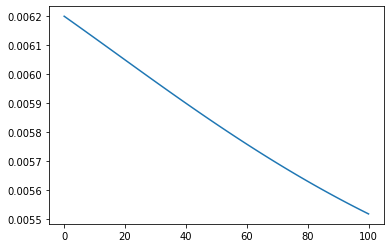

In [44]:
train_loss_ = [train_loss[i].item() for i in range(len(train_loss))]

plt.plot(train_loss_)

In [7]:
path_test_masks = os.path.join(path, 'test', 'mask')
path_test = os.path.join(path, 'test')

names_ = [f[:-25] for f in os.listdir(path_test_masks) if f.endswith('png') and 'sheet' in f]
print(len(names_))
names_.sort()


mask_nod = [ f  for f in os.listdir(path_test_masks) if f.endswith('png') and 'nodular' in f and  f[:-27] in names_ ]
names  = [f[:-27] for f in mask_nod ]

mask_nod = [ os.path.join(path_test_masks, f)  for f in os.listdir(path_test_masks) if f.endswith('png') and 'nodular' in f and  f[:-27] in names_ ]
mask_sh = [os.path.join(path_test_masks, f) for f in os.listdir(path_test_masks) if f.endswith('png') and 'sheet' in f  and  f[:-25] in names ]
#mask_bck = [os.path.join(path_test_masks, f) for f in os.listdir(path_test_masks) if f.endswith('png') and 'ale._nonbck' in f  and f[:-22] in names]
#mask_bck = [os.path.join(path_test_masks, f) for f in os.listdir(path_test_masks) if f.endswith('png') and 'nonbck' in f  and f[:-22] in names]

image_Paths  = [os.path.join(path_test_masks, f) for f in os.listdir(path_test_masks) if (f.endswith('grayscale.png') or f.endswith('greyscale.png') )  and f[:-14] in names]
print(len(mask_nod), len(mask_sh), len(image_Paths))
#print(len(mask_nod), len(mask_sh), len(mask_bck), len(image_Paths))
mask_nod.sort()
mask_sh.sort()
#mask_bck.sort()
image_Paths.sort()

#mask_Paths  = [[nod, sh, bck]  for nod, sh, bck in zip(mask_nod,mask_sh,mask_bck) ]
mask_Paths_test  = [[nod, sh]  for nod, sh in zip(mask_nod,mask_sh) ]

10
9 9 9


In [8]:
error = 20
Area = 100
image_list = []
mask_list = []

for idx in range(len(mask_Paths_test)):
    #print(idx)
    mask =  create_binary_mask(mask_Paths_test, idx)
    image = read_image(image_Paths[idx], False )
    masks_imgs, imgs = box_image_seg(mask, image, error, Area)
    image_list += imgs
    mask_list += masks_imgs
print('Images and masks are created')
print(len(image_list), len(mask_list))     

Images and masks are created
22 22


In [13]:
#modelPath = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Proba_UNET'
net.load_state_dict(torch.load(os.path.join(modelPath , '100.torch'))) # Load trained model
net.eval()

Probabilistic_UNET(
  (priori): priori(
    (p_z): Sequential(
      (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (conv_layer): Conv2d(16, 20, kernel_size=(1, 1), stride=(1, 1))
  )
  (UNET): UNET(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=

In [14]:
data_test = SegmentationDataset(image_list, mask_list, image_shape)
dataloaders_test = torch.utils.data.DataLoader(data_test, 1)


for index, batch in enumerate(dataloaders_test): 
    X, y = batch

    X, y = X.to(device), y.to(device)
    _,_, pred =  net(X, y)
    print(X.shape, y.shape, pred.shape)

torch.Size([1, 3, 128, 128]) torch.Size([1, 128, 128]) torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128]) torch.Size([1, 128, 128]) torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128]) torch.Size([1, 128, 128]) torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128]) torch.Size([1, 128, 128]) torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128]) torch.Size([1, 128, 128]) torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128]) torch.Size([1, 128, 128]) torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128]) torch.Size([1, 128, 128]) torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128]) torch.Size([1, 128, 128]) torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128]) torch.Size([1, 128, 128]) torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128]) torch.Size([1, 128, 128]) torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128]) torch.Size([1, 128, 128]) torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128]) torch.Size([1, 128, 128]) torch.Size([1, 3, 128

tensor(0.5803, grad_fn=<RsubBackward1>)


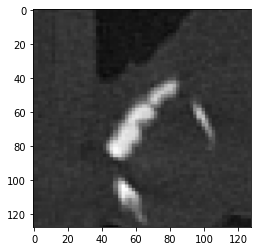

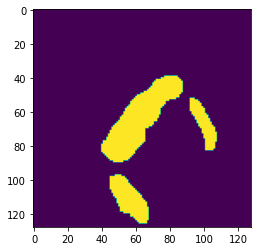

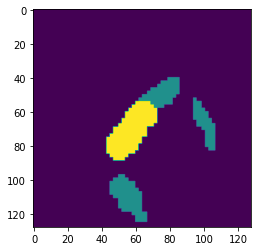

tensor(0.5564, grad_fn=<RsubBackward1>)


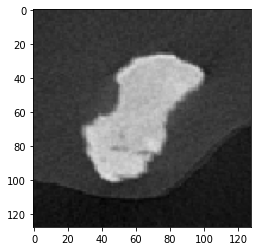

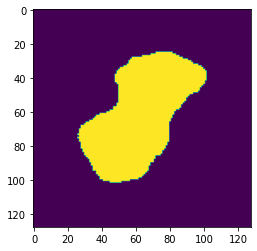

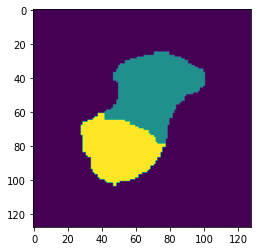

tensor(0.5827, grad_fn=<RsubBackward1>)


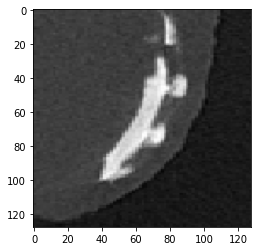

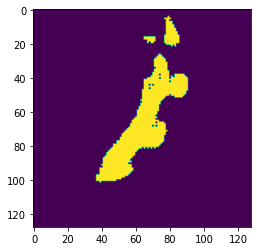

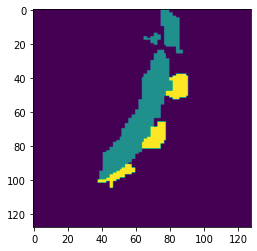

tensor(0.5724, grad_fn=<RsubBackward1>)


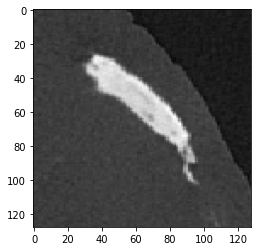

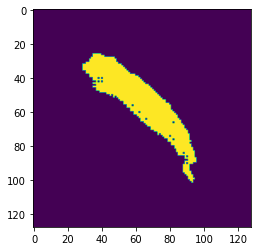

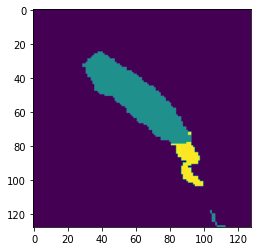

tensor(0.6052, grad_fn=<RsubBackward1>)


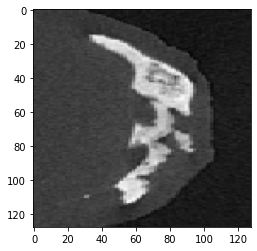

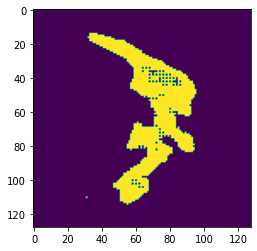

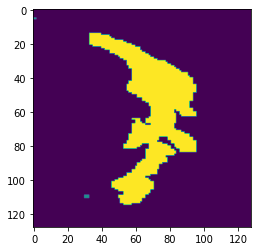

tensor(0.5168, grad_fn=<RsubBackward1>)


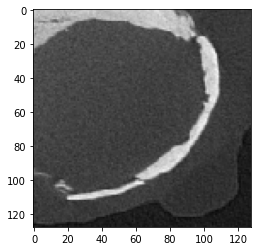

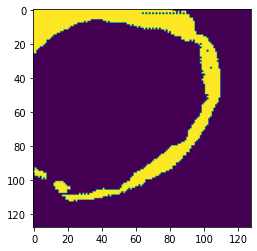

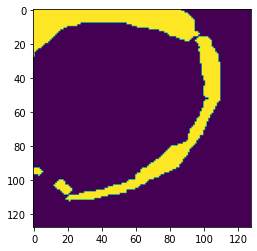

tensor(0.5585, grad_fn=<RsubBackward1>)


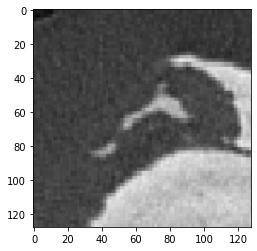

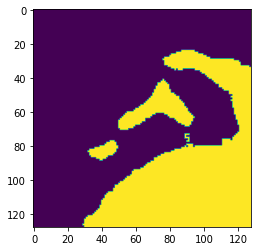

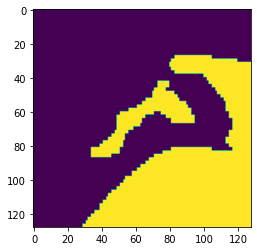

tensor(0.5231, grad_fn=<RsubBackward1>)


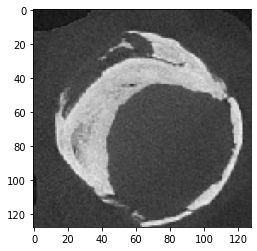

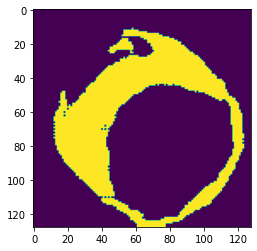

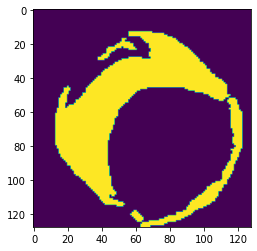

tensor(0.6351, grad_fn=<RsubBackward1>)


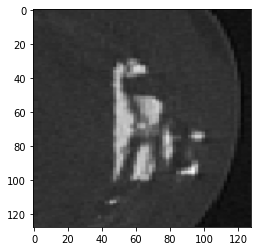

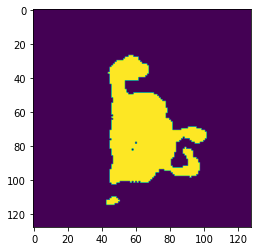

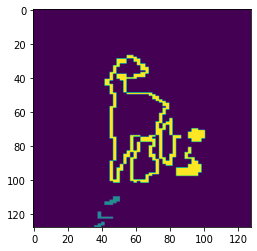

tensor(0.6362, grad_fn=<RsubBackward1>)


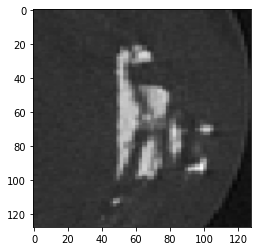

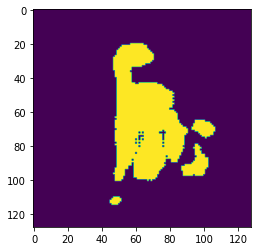

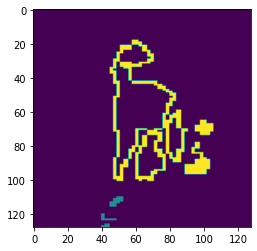

tensor(0.5855, grad_fn=<RsubBackward1>)


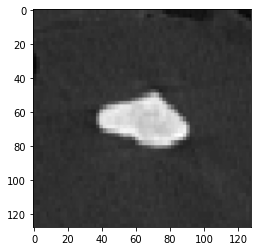

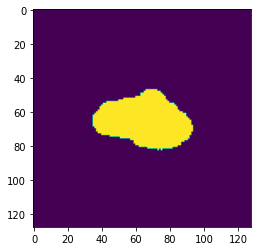

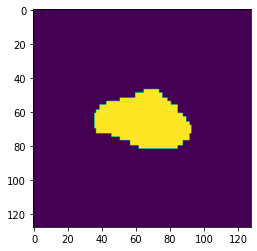

tensor(0.5600, grad_fn=<RsubBackward1>)


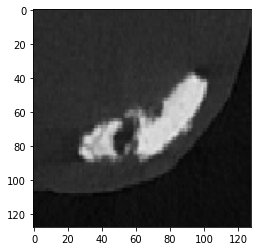

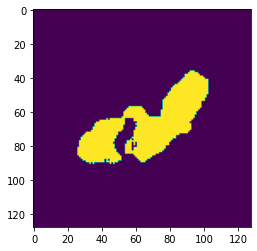

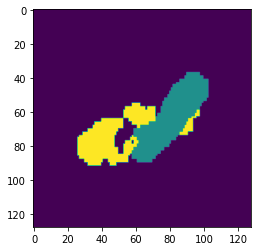

tensor(0.5881, grad_fn=<RsubBackward1>)


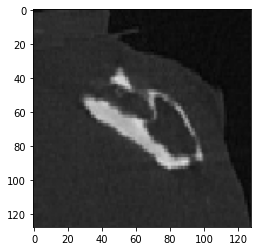

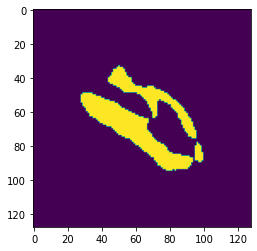

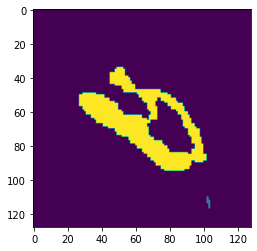

tensor(0.5664, grad_fn=<RsubBackward1>)


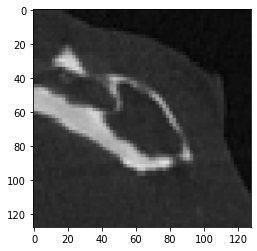

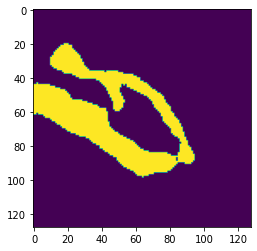

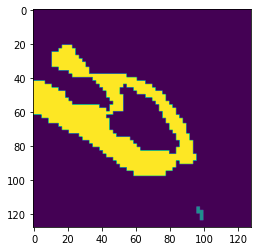

tensor(0.5669, grad_fn=<RsubBackward1>)


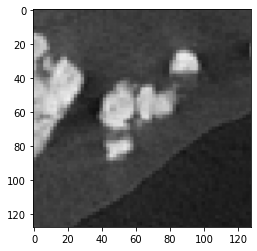

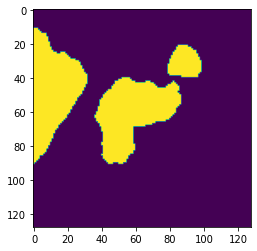

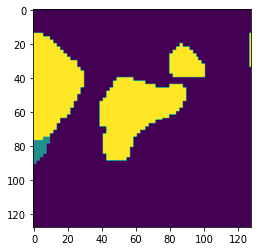

tensor(0.6090, grad_fn=<RsubBackward1>)


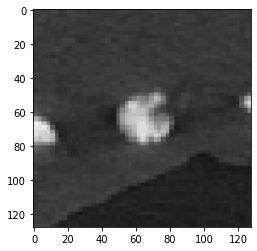

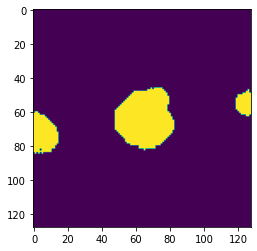

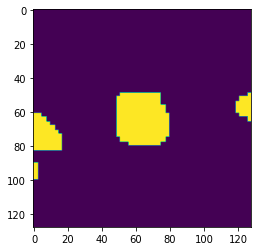

tensor(0.4964, grad_fn=<RsubBackward1>)


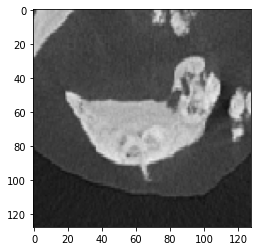

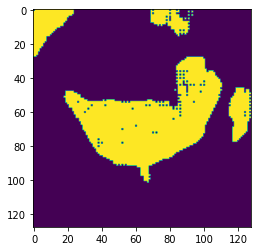

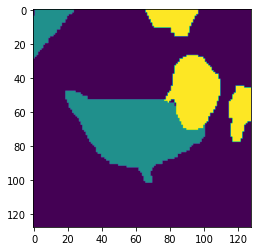

tensor(0.5440, grad_fn=<RsubBackward1>)


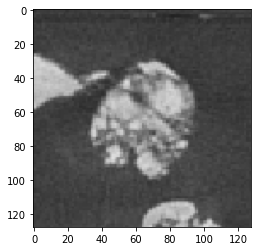

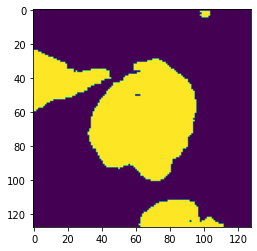

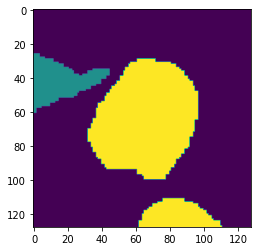

tensor(0.5634, grad_fn=<RsubBackward1>)


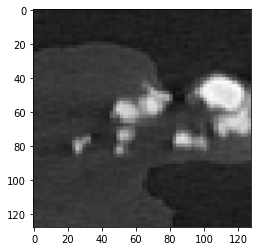

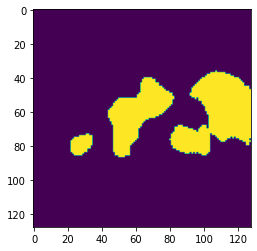

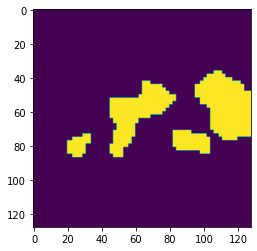

tensor(0.5199, grad_fn=<RsubBackward1>)


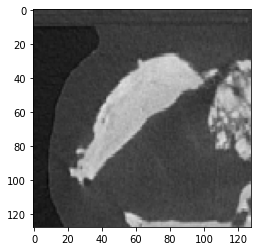

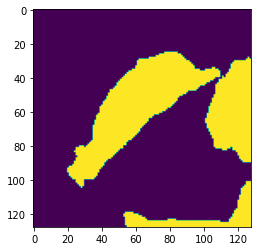

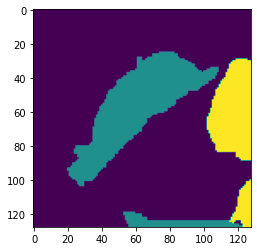

tensor(0.5741, grad_fn=<RsubBackward1>)


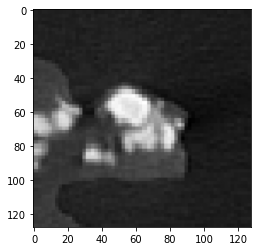

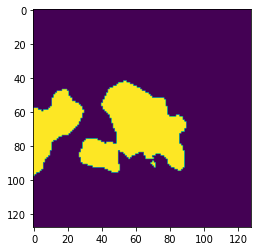

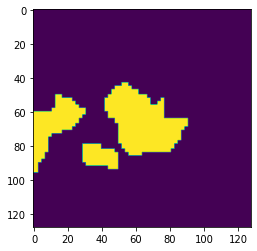

tensor(0.5481, grad_fn=<RsubBackward1>)


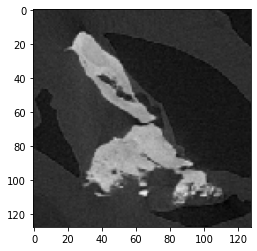

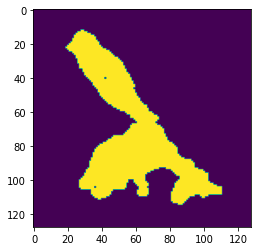

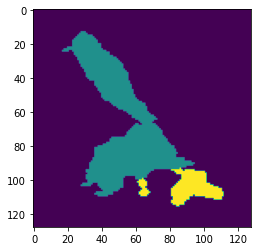

In [15]:
loss_fn  =  DiceLoss() 

data_test = SegmentationDataset(image_list, mask_list, image_shape)
dataloaders_test = torch.utils.data.DataLoader(data_test, 1)

for index, batch in enumerate(dataloaders_test): 
    X, y = batch

    X, y = X.to(device), y.to(device)
    _,_, pred =  net(X, y)
    seg = torch.argmax(pred, dim=1).numpy()[0]# torch.argmax(pred, 1).numpy()  # Get  prediction classes
    print(loss_fn(pred, y))
    plt.imshow(X.squeeze().permute(1,2,0))
    plt.show()
    plt.imshow(seg)
    plt.show()
    plt.imshow(y.squeeze())
    plt.show()